# Tuning SCREAM for RNA-ATAC data

For this tutorial, we will use the Cell-line SNARE-seq dataset (Original paper: https://www.nature.com/articles/s41587-019-0290-0). Briefly, there are 1047 cells with paired RNA-seq and ATAC-seq data drawn from mixtures of cultured human BJ, H1, K562 and GM12878 cell lines.

In [1]:
import os
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
import sys
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import scanpy as sc
import muon as mu
import keras_tuner as kt
from functools import partial
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

mu.set_options(pull_on_update=False)

2025-09-06 16:07:52.893308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import SCREAM

## Define directories

Change this according to your directory structure.

In [41]:
mainDir = os.getcwd()
inputDir = os.path.join(mainDir, 'inputfiles')
rawDir = os.path.join(mainDir, 'inputfiles', 'raw')
processedDir = os.path.join(mainDir, 'inputfiles', 'processed')
results_dir = os.path.join(mainDir, 'results')

## Define global settings

In [4]:
sc.set_figure_params(dpi=100, color_map='viridis_r')
%matplotlib inline

In [5]:
print(f'Time before running script: {datetime.datetime.now().strftime("%d %b %Y %H:%M:%S")}')

Time before running script: 06 Sep 2025 16:08:57


In [6]:
t_start = datetime.datetime.now()

## Read data

SCREAM requires Anndata of each modality to be provided as input to the model. In this section, we will be reading the input files and converting them to Anndata format.

### Read cell metadata

In [7]:
cell_meta_snare = pd.read_table(os.path.join(rawDir, 'cellline', 'cell_metadata.txt'), index_col=0)
display(cell_meta_snare)

,cell_line
cell,
ACTTTCTAATCA,BJ
GAGAGAAAACCT,H1
TACGGCTGTTAT,K562
GACGCGTAAGTG,BJ
GAAAGGACTGCA,BJ
...,...
GTTCTTCCTAGT,H1
ATCCGTTCAACG,H1
CCGACTAAGAAT,K562


### Read RNA-seq data

In [8]:
rna_snare_df = pd.read_table(os.path.join(rawDir, 'cellline', 'scRNA_seq_SNARE.tsv'), index_col=0).T
rna_snare_adata = sc.AnnData(rna_snare_df, obs=cell_meta_snare)
display(rna_snare_adata)

AnnData object with n_obs × n_vars = 1047 × 500
    obs: 'cell_line'

### Read ATAC-seq data

In [9]:
atac_snare_df = pd.read_table(os.path.join(rawDir, 'cellline', 'scATAC_seq_SNARE.txt'), index_col=0).T
atac_snare_adata = sc.AnnData(atac_snare_df, obs=cell_meta_snare)
display(atac_snare_adata)

AnnData object with n_obs × n_vars = 1047 × 7136
    obs: 'cell_line'

## Tuning

### Initialize SCREAM

1. SCREAM requires a folder to be defined where it can save the model configuration, encoders and tuning results. If none provided, it will  use the current working directory.
2. Setting logger = True enables logging for tensorboard visualization.

In [10]:
model_result_dir = os.path.join(results_dir, 'scream_cellline_hyper_large_new2')
scream_model = SCREAM.models.scream.SCREAM({'RNA': rna_snare_adata, "ATAC": atac_snare_adata}, save_dir=model_result_dir, logger=True)

Trained models will be saved at: /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2
MuData object with n_obs × n_vars = 1047 × 7636
  2 modalities
    RNA:	1047 x 500
      obs:	'cell_line'
    ATAC:	1047 x 7136
      obs:	'cell_line'


### Define the tuning model

We perform tuning to determine the optimal number of encoding layers for SAE and the dropout. 
Tuning in SCREAM uses the keras-tuner package. This requires the SAE modules to be wrapped with a keras-tuner hypermodel, which can be done as below.

In [11]:
class SAEHyperModel(kt.HyperModel):
    def __init__(self, X, log_dir=None, earlyStop=True, decay_epochs=50, min_lr=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.X = X.copy()
        if not hasattr(self, 'name'):
            self.name = 'dataset'

        self.hyper_callbacks = []
        if earlyStop:
            self.hyper_callbacks.append(SCREAM.models.tools.CustomReduceLROnPlateau(monitor='loss', min_delta=1e-4, patience=10,
                                                                                    verbose=1, mode='auto', max_lr_epochs=decay_epochs, min_lr=min_lr))
        else:
            self.hyper_callbacks.append(LearningRateScheduler(partial(self.scheduler, factor=0.1, decay_step=decay_epochs, min_lr=min_lr)))

        if log_dir is not None:
            self.log_dir = log_dir
            self.hyper_callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(self.log_dir, self.name, 'tb'), update_freq='epoch'))

    @staticmethod
    def scheduler(epoch, lr, factor, decay_step, min_lr):
        return np.max([np.round(lr * factor, 6), min_lr]) if epoch > 0 and epoch % decay_step == 0 else lr

    def build(self, hp):
        encoding_layer_dims = [hp.Int('layer1_units', min_value=128, max_value=1024, step=32),
                               hp.Int('layer2_units', min_value=12, max_value=256, step=32)]

        default_sae_kwargs = {'act': 'relu', 'drop_rate': hp.Float('dropout', min_value=0, max_value=0.3, step=0.1),
                              'random_seed': 201809, 'actincenter': "tanh", 'init': "glorot_uniform",
                              'use_earlyStop': True, 'suffix': '_'+self.name, 'pretrain_stacks': True}
        sae = SCREAM.models.SAE.SAE(dims=[self.X.shape[-1]] + encoding_layer_dims, **default_sae_kwargs)

        pretrain_epochs = 300
        decaying_step = 3
        if sae.stack_pretrain is True:
            sae.pretrain_stacks(self.X, epochs=int(pretrain_epochs), decaying_step=decaying_step)
            print('Copying layer-wise pretrained weights to deep autoencoders')

            for i in np.arange(sae.n_stacks):
                sae.autoencoders.get_layer(f'encoder_{i}{sae.suffix}').set_weights(sae.stacks[i].get_layer('encoder').get_weights())
                sae.autoencoders.get_layer(f'decoder_{i}{sae.suffix}').set_weights(sae.stacks[i].get_layer('decoder').get_weights())

        init_lr = hp.Float("learning_rate", min_value=0.001, max_value=0.1, step=10, sampling="log")
        sae.autoencoders.compile(optimizer=SGD(init_lr, momentum=0.9), loss='mse')

        return sae.autoencoders


def create_mod_hmodel(mdata, modality, log_dir, obsm_key=None):
    assert modality in mdata.mod_names, (f'Modality {modality} not found in mudata. Must be one of {mdata.mod_names}.')
    if obsm_key is None:
        X_all_data = mdata.mod[modality].X.copy()
    else:
        X_all_data = mdata.mod[modality].obsm[obsm_key].copy()

    return SAEHyperModel(X_all_data, log_dir=log_dir, name=modality), X_all_data


def create_joint_hmodel(mdata, modalities, log_dir, obsm_key=None):
    if modalities is not None:
        assert isinstance(modalities, list) and set(modalities).issubset(set(mdata.mod_names))
    else:
        modalities = mdata.mod_names

    ls_mat = []
    ls_names = []
    for i, modality in enumerate(modalities):
        ls_names.append([modality+'_ls_'+str(i+1) for i in np.arange(mdata.mod[modality].obsm[obsm_key].shape[1])])
        ls_mat.append(mdata.mod[modality].obsm[obsm_key])

    X_all_data = np.concatenate(ls_mat, axis=1)

    return SAEHyperModel(X_all_data, log_dir=log_dir, name='_'.join(modalities)+'_joint'), X_all_data

### Stage 1: Train individual modalities

#### RNA SAE tuning

In [12]:
hyper_model, X = create_mod_hmodel(scream_model.mdata_train, modality='RNA', log_dir=model_result_dir, obsm_key=None)
tuner = kt.BayesianOptimization(hyper_model,
                                objective='loss',
                                directory=hyper_model.log_dir,
                                project_name=hyper_model.name,
                                max_trials=50)

Reloading Tuner from /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/RNA/tuner0.json


In [13]:
display(tuner.search_space_summary(extended=True))

Search space summary
Default search space size: 4
layer1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
layer2_units (Int)
{'default': None, 'conditions': [], 'min_value': 12, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 10, 'sampling': 'log'}


None

In [14]:
tuner.search(X, X, epochs=300, validation_split=0.2, callbacks=hyper_model.hyper_callbacks)
tuner.results_summary()

Trial 50 Complete [00h 01m 15s]
loss: 0.7833591103553772

Best loss So Far: 0.7833147644996643
Total elapsed time: 11d 04h 44m 12s
Results summary
Results in /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/RNA
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 17 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.7833147644996643

Trial 19 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.7833147644996643

Trial 18 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.7833147644996643

Trial 15 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.7833147644996643

Trial 20 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.7833147644996643

Trial 16 summary
Hyperparameters:
layer1

In [15]:
best_hps_rna = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The hyperparameter search is complete. The optimal hyperparameters are: \n {best_hps_rna.values}")

The hyperparameter search is complete. The optimal hyperparameters are: 
 {'layer1_units': 1024, 'layer2_units': 236, 'dropout': 0.0, 'learning_rate': 0.1}


#### ATAC SAE tuning

In [16]:
hyper_model, X = create_mod_hmodel(scream_model.mdata_train, modality='ATAC', log_dir=model_result_dir, obsm_key=None)
tuner = kt.BayesianOptimization(hyper_model,
                                objective='loss',
                                directory=hyper_model.log_dir,
                                project_name=hyper_model.name, 
                                max_trials=50)

Reloading Tuner from /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/ATAC/tuner0.json


In [17]:
display(tuner.search_space_summary(extended=True))

Search space summary
Default search space size: 4
layer1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
layer2_units (Int)
{'default': None, 'conditions': [], 'min_value': 12, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 10, 'sampling': 'log'}


None

In [18]:
tuner.search(X, X, epochs=300, validation_split=0.2, callbacks=hyper_model.hyper_callbacks)
tuner.results_summary()

Trial 50 Complete [00h 00m 39s]
loss: 0.008814365603029728

Best loss So Far: 0.008793405257165432
Total elapsed time: 11d 04h 32m 54s
Results summary
Results in /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/ATAC
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 38 summary
Hyperparameters:
layer1_units: 800
layer2_units: 12
dropout: 0.0
learning_rate: 0.1
Score: 0.008793405257165432

Trial 24 summary
Hyperparameters:
layer1_units: 800
layer2_units: 12
dropout: 0.0
learning_rate: 0.1
Score: 0.008793405257165432

Trial 34 summary
Hyperparameters:
layer1_units: 800
layer2_units: 12
dropout: 0.0
learning_rate: 0.1
Score: 0.008793405257165432

Trial 41 summary
Hyperparameters:
layer1_units: 800
layer2_units: 12
dropout: 0.0
learning_rate: 0.1
Score: 0.008793405257165432

Trial 45 summary
Hyperparameters:
layer1_units: 800
layer2_units: 12
dropout: 0.0
learning_rate: 0.1
Score: 0.008793406188488007

Trial 46 summary
Hyperparameters:
l

In [19]:
best_hps_atac = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The hyperparameter search is complete. The optimal hyperparameters are: \n {best_hps_atac.values}")

The hyperparameter search is complete. The optimal hyperparameters are: 
 {'layer1_units': 800, 'layer2_units': 12, 'dropout': 0.0, 'learning_rate': 0.1}


#### Train modalities on best hyper parameters

This is the section where we use the recommendations from keras tuner for the best hyper-parameter configuration to train our model.

In [20]:
sae_rna = scream_model.pretrain_modality(modality='RNA', encoding_layer_dims=[1024, 236], drop_rate=0.0, batch_size=50, train_test_split=None, save_encoder=True)

Folder already exists
{'drop_rate': 0.0, 'batch_size': 50}


Model: "AE_RNA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_RNA (InputLayer)          │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0_RNA (Dense)           │ (None, 1024)           │       513,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1_RNA (Dense)           │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1_RNA (Dense)           │ (None, 1024)           │       242,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0_RNA (Dense)           │ (None, 500)            │       512,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,510,112 (5.76 MB)

 Trainable params: 1,510,112 (5.76 MB)

 Non-trainable params: 0 (0.00 B)

None
Pretraining layer 1...
Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7844 - lr: 0.1000
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7116 - lr: 0.1000
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6953 - lr: 0.1000
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 - lr: 0.1000
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6834 - lr: 0.1000
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6803 - lr: 0.1000
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6779 - lr: 0.1000
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6759 - lr: 0.1000
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6743 - lr: 0.1000
Epoch 10/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6730 - lr: 0.1000
Epoch 11/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6717 - lr: 0.1000
Epoch 12/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6707 - lr: 0.1000
Epoch 13/150
21/21 ━

In [21]:
# SCREAM.models.tools.plot_architecture(sae_rna.autoencoders, to_file=os.path.join(model_result_dir, 'rna_ae.svg'), rankdir='LR')

In [22]:
sae_atac = scream_model.pretrain_modality(modality='ATAC', encoding_layer_dims=[800, 12], drop_rate=0.0, batch_size=50, train_test_split=None, save_encoder=True)

Folder already exists
{'drop_rate': 0.0, 'batch_size': 50}


Model: "AE_ATAC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ATAC (InputLayer)         │ (None, 7136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0_ATAC (Dense)          │ (None, 800)            │     5,709,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1_ATAC (Dense)          │ (None, 12)             │         9,612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1_ATAC (Dense)          │ (None, 800)            │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0_ATAC (Dense)          │ (None, 7136)           │     5,715,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,445,548 (43.66 MB)

 Trainable params: 11,445,548 (43.66 MB)

 Non-trainable params: 0 (0.00 B)

None
Pretraining layer 1...
Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0101 - lr: 0.1000
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - lr: 0.1000
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - lr: 0.1000
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - lr: 0.1000
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - lr: 0.1000
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - lr: 0.1000
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - lr: 0.1000
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - lr: 0.1000
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - lr: 0.1000
Epoch 10/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - lr: 0.1000
Epoch 11/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - lr: 0.1000
Epoch 12/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - lr: 0.1000
Epoch 13/150
21/21 ━

In [23]:
# SCREAM.models.tools.plot_architecture(sae_atac.autoencoders, to_file=os.path.join(model_result_dir, 'atac_ae.svg'), rankdir='LR')

### Stage 2: Train on joint latent space

In this section, we can tune our joint SAE module which takes the fused modality inputs as features.

#### Tuning joint space

In [24]:
hyper_model, X = create_joint_hmodel(scream_model.mdata_train, modalities=['RNA', 'ATAC'], log_dir=model_result_dir, obsm_key='X_desc_ls')
tuner = kt.BayesianOptimization(hyper_model,
                                objective='loss',
                                directory=hyper_model.log_dir,
                                project_name=hyper_model.name,
                                max_trials=50)

Reloading Tuner from /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/RNA_ATAC_joint/tuner0.json


In [25]:
display(tuner.search_space_summary(extended=True))

Search space summary
Default search space size: 4
layer1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
layer2_units (Int)
{'default': None, 'conditions': [], 'min_value': 12, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 10, 'sampling': 'log'}


None

In [26]:
tuner.search(X, X, epochs=300, validation_split=0.2, callbacks=hyper_model.hyper_callbacks)
tuner.results_summary()

Trial 50 Complete [00h 00m 53s]
loss: 0.008199234493076801

Best loss So Far: 0.008199234493076801
Total elapsed time: 11d 04h 04m 48s
Results summary
Results in /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/RNA_ATAC_joint
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 20 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.008199234493076801

Trial 21 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.008199234493076801

Trial 22 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.008199234493076801

Trial 23 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.008199234493076801

Trial 24 summary
Hyperparameters:
layer1_units: 1024
layer2_units: 236
dropout: 0.0
learning_rate: 0.1
Score: 0.008199234493076801

Trial 25 summar

In [27]:
best_hps_joint = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The hyperparameter search is complete. The optimal hyperparameters are: \n {best_hps_joint.values}")

The hyperparameter search is complete. The optimal hyperparameters are: 
 {'layer1_units': 1024, 'layer2_units': 236, 'dropout': 0.0, 'learning_rate': 0.1}


#### Training on best hyper parameters

leiden_res defines the resolution of clustering. If multiple are provided, the model will train an autoencoder once and then use the encoder portion in the clustering module for each resolution individually. 

In [28]:
default_scream_opts = {'tol': 0.0001, 'n_neighbors': 15,
                       'batch_size': 50, 'method': 'leiden',
                       'do_tsne': True, 'tsne_kwargs': {'learning_rate': 200}, 'gpu_device': None,
                       'save_encoder_weights': False, 'use_ae_weights': False,
                       'do_umap': True, 'save_clustering_model': True}

In [29]:
leiden_res = list(np.linspace(0.1, 1, num=10).round(decimals=2))
leiden_res.append(0.05)
ae_combined = scream_model.train_joint(modalities=None, clustering_resolutions=leiden_res, encoding_layer_dims=[1024, 236], **default_scream_opts)

Folder already exists
{'tol': 0.0001, 'n_neighbors': 15, 'batch_size': 50, 'method': 'leiden', 'save_encoder_weights': False, 'use_ae_weights': False}
{'learning_rate': 200}
The number of available cores is 40.
The number of cores used for training is 10.
Start to process resolution: 0.1
Training will be done on CPU.
Runtime for resolution 0.1 (HH:MM:SS): 0:00:00.000013
Rerunning autoencoder
Logged at /scratch/g/tgu/svenkatesan/Other/SCREAM_wf/results/scream_cellline_hyper_large_new2/RNA_ATAC_joint/pretrain
Pretraining layer 1...
Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1064 - lr: 0.1000
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0579 - lr: 0.1000
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 - lr: 0.1000
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402 - lr: 0.1000
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - lr: 0.1000
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - 

/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/scratch/g/tgu/svenkatesan/Other/SCREAM_wf/SCREAM/models/network.py:232: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata0, resolution=self.resolution)


The value of delta_label of current 1th iteration is: 0.051575932651758194 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0899
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0744 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513 
The value of delta_label of current 2th iteration is: 0.03915950283408165 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1206 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1073 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0962 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0870 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0792 
The value of delta_label of current 3th iteration is: 0.012416427955031395 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1365 
Epoch 2/5
21/21 ━━━

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 4)              │           944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 995,642 (3.80 MB)

 Trainable params: 497,820 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 497,822 (1.90 MB)

UMAP finished and added X_umap0.1 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.1 into adata.obsm

Start to process resolution: 0.2
Training will be done on CPU.
Runtime for resolution 0.2 (HH:MM:SS): 0:00:00.000024
Pretraining time (HH:MM:SS): 0:00:00.039212
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.04966571182012558 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0899
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0744 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513 
The value of delta_label of current 2th iteration is: 0.037249282002449036 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1206 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1073 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0962 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0870 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0792 
The value of delta_label of current 3th iteration is: 0.011461318470537663 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1365 
Epoch 2/5
21/21 ━━━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 4)              │           944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 995,642 (3.80 MB)

 Trainable params: 497,820 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 497,822 (1.90 MB)

UMAP finished and added X_umap0.2 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.2 into adata.obsm

Start to process resolution: 0.3
Training will be done on CPU.
Runtime for resolution 0.3 (HH:MM:SS): 0:00:00.000012
Pretraining time (HH:MM:SS): 0:00:00.036608
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.18051576614379883 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1183
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1034 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0927 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0841 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0767 
The value of delta_label of current 2th iteration is: 0.04584527388215065 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1500 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1372 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1260 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1165 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1082 
The value of delta_label of current 3th iteration is: 0.025787966325879097 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1677 
Epoch 2/5
21/21 ━━━━

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 5)              │         1,180 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,114 (3.80 MB)

 Trainable params: 498,056 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 498,058 (1.90 MB)

UMAP finished and added X_umap0.3 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.3 into adata.obsm

Start to process resolution: 0.4
Training will be done on CPU.
Runtime for resolution 0.4 (HH:MM:SS): 0:00:00.000016
Pretraining time (HH:MM:SS): 0:00:00.038247
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.11079274117946625 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1286
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1123 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1025 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0947 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0880 
The value of delta_label of current 2th iteration is: 0.06590257585048676 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1643 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1507 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1405 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1317 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1240 
The value of delta_label of current 3th iteration is: 0.044890161603689194 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1850 
Epoch 2/5
21/21 ━━━━

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 6)              │         1,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,586 (3.80 MB)

 Trainable params: 498,292 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 498,294 (1.90 MB)

UMAP finished and added X_umap0.4 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.4 into adata.obsm

Start to process resolution: 0.5
Training will be done on CPU.
Runtime for resolution 0.5 (HH:MM:SS): 0:00:00.000008
Pretraining time (HH:MM:SS): 0:00:00.035566
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.17382998764514923 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1307
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1150 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1048 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0964 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0893 
The value of delta_label of current 2th iteration is: 0.054441262036561966 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1649 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1517 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1412 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1322 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1243 
The value of delta_label of current 3th iteration is: 0.03629417344927788 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1850 
Epoch 2/5
21/21 ━━━━

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 6)              │         1,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,586 (3.80 MB)

 Trainable params: 498,292 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 498,294 (1.90 MB)

UMAP finished and added X_umap0.5 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.5 into adata.obsm

Start to process resolution: 0.6
Training will be done on CPU.
Runtime for resolution 0.6 (HH:MM:SS): 0:00:00.000013
Pretraining time (HH:MM:SS): 0:00:00.039464
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.11747851222753525 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1337
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1167 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1058 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0969 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0892 
The value of delta_label of current 2th iteration is: 0.051575932651758194 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1706 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1565 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1448 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1347 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1258 
The value of delta_label of current 3th iteration is: 0.02483285591006279 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1910 
Epoch 2/5
21/21 ━━━━

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 6)              │         1,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,586 (3.80 MB)

 Trainable params: 498,292 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 498,294 (1.90 MB)

UMAP finished and added X_umap0.6 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.6 into adata.obsm

Start to process resolution: 0.7
Training will be done on CPU.
Runtime for resolution 0.7 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.036275
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.10410697013139725 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1528
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1368 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1264 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1177 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1102 
The value of delta_label of current 2th iteration is: 0.06972301751375198 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1915 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1785 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1678 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1585 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1503 
The value of delta_label of current 3th iteration is: 0.026743074879050255 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2147 
Epoch 2/5
21/21 ━━━━

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 8)              │         1,888 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 997,530 (3.81 MB)

 Trainable params: 498,764 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 498,766 (1.90 MB)

UMAP finished and added X_umap0.7 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.7 into adata.obsm

Start to process resolution: 0.8
Training will be done on CPU.
Runtime for resolution 0.8 (HH:MM:SS): 0:00:00.000008
Pretraining time (HH:MM:SS): 0:00:00.034298
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.1117478534579277 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1521
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1362 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1259 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1173 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1097 
The value of delta_label of current 2th iteration is: 0.0649474710226059 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1906 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1777 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1670 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1577 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1495 
The value of delta_label of current 3th iteration is: 0.030563514679670334 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2140 
Epoch 2/5
21/21 ━━━━━━

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 8)              │         1,888 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 997,530 (3.81 MB)

 Trainable params: 498,764 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 498,766 (1.90 MB)

UMAP finished and added X_umap0.8 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.8 into adata.obsm

Start to process resolution: 0.9
Training will be done on CPU.
Runtime for resolution 0.9 (HH:MM:SS): 0:00:00.000007
Pretraining time (HH:MM:SS): 0:00:00.040914
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.09360076487064362 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1553
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1393 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1295 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1212 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1141 
The value of delta_label of current 2th iteration is: 0.062082137912511826 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1959 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1832 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1728 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1638 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1559 
The value of delta_label of current 3th iteration is: 0.03629417344927788 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2211 
Epoch 2/5
21/21 ━━━━

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 9)              │         2,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,002 (3.81 MB)

 Trainable params: 499,000 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 499,002 (1.90 MB)

UMAP finished and added X_umap0.9 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.9 into adata.obsm

Start to process resolution: 1.0
Training will be done on CPU.
Runtime for resolution 1.0 (HH:MM:SS): 0:00:00.000011
Pretraining time (HH:MM:SS): 0:00:00.038207
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.09264565259218216 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1559
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1398 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1299 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1216 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1144 
The value of delta_label of current 2th iteration is: 0.06876790523529053 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1967 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1839 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1736 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1645 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1566 
The value of delta_label of current 3th iteration is: 0.03151862323284149 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2217 
Epoch 2/5
21/21 ━━━━━

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 9)              │         2,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,002 (3.81 MB)

 Trainable params: 499,000 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 499,002 (1.90 MB)

UMAP finished and added X_umap1.0 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne1.0 into adata.obsm

Start to process resolution: 0.05
Training will be done on CPU.
Runtime for resolution 0.05 (HH:MM:SS): 0:00:00.000013
Pretraining time (HH:MM:SS): 0:00:00.038618
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
...number of clusters is unknown, Initialize cluster centroid using leiden method


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


The value of delta_label of current 1th iteration is: 0.014326647855341434 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0243
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 
The value of delta_label of current 2th iteration is: 0.0047755492851138115 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309 
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 
The value of delta_label of current 3th iteration is: 0.0047755492851138115 >= tol 0.0001
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 
Epoch 2/5
21/21 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 248)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 1024)           │       254,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 236)            │       241,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 2)              │           472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 994,698 (3.79 MB)

 Trainable params: 497,348 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 497,350 (1.90 MB)

UMAP finished and added X_umap0.05 into adata.obsm



/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  return fn(*args_all, **kw)


TSNE finished and added X_tsne0.05 into adata.obsm

Total time to run DESC (HH:MM:SS): 0:04:54.915920
MuData object with n_obs × n_vars = 1047 × 7636
  obs:	'desc_0.1', 'desc_0.2', 'desc_0.3', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9', 'desc_1.0', 'desc_0.05'
  uns:	'prob_matrix0.1', 'umap', 'tsne', 'prob_matrix0.2', 'prob_matrix0.3', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8', 'prob_matrix0.9', 'prob_matrix1.0', 'prob_matrix0.05'
  obsm:	'joint_ls', 'X_Embedded_z0.1', 'X_umap', 'X_umap0.1', 'X_tsne', 'X_tsne0.1', 'X_Embedded_z0.2', 'X_umap0.2', 'X_tsne0.2', 'X_Embedded_z0.3', 'X_umap0.3', 'X_tsne0.3', 'X_Embedded_z0.4', 'X_umap0.4', 'X_tsne0.4', 'X_Embedded_z0.5', 'X_umap0.5', 'X_tsne0.5', 'X_Embedded_z0.6', 'X_umap0.6', 'X_tsne0.6', 'X_Embedded_z0.7', 'X_umap0.7', 'X_tsne0.7', 'X_Embedded_z0.8', 'X_umap0.8', 'X_tsne0.8', 'X_Embedded_z0.9', 'X_umap0.9', 'X_tsne0.9', 'X_Embedded_z1.0', 'X_umap1.0', 'X_tsne1.0', 

In [30]:
# SCREAM.models.tools.plot_architecture(ae_combined.model, to_file=os.path.join(model_result_dir, 'joint_ae.svg'), rankdir='LR')

In [31]:
display(scream_model.mdata_train)

MuData object with n_obs × n_vars = 1047 × 7636
  obs:	'desc_0.1', 'desc_0.2', 'desc_0.3', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9', 'desc_1.0', 'desc_0.05'
  uns:	'prob_matrix0.1', 'umap', 'tsne', 'prob_matrix0.2', 'prob_matrix0.3', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8', 'prob_matrix0.9', 'prob_matrix1.0', 'prob_matrix0.05'
  obsm:	'joint_ls', 'X_Embedded_z0.1', 'X_umap', 'X_umap0.1', 'X_tsne', 'X_tsne0.1', 'X_Embedded_z0.2', 'X_umap0.2', 'X_tsne0.2', 'X_Embedded_z0.3', 'X_umap0.3', 'X_tsne0.3', 'X_Embedded_z0.4', 'X_umap0.4', 'X_tsne0.4', 'X_Embedded_z0.5', 'X_umap0.5', 'X_tsne0.5', 'X_Embedded_z0.6', 'X_umap0.6', 'X_tsne0.6', 'X_Embedded_z0.7', 'X_umap0.7', 'X_tsne0.7', 'X_Embedded_z0.8', 'X_umap0.8', 'X_tsne0.8', 'X_Embedded_z0.9', 'X_umap0.9', 'X_tsne0.9', 'X_Embedded_z1.0', 'X_umap1.0', 'X_tsne1.0', 'X_Embedded_z0.05', 'X_umap0.05', 'X_tsne0.05'
  2 modalities
    RNA:	1047 x 500
      obs:	'cell_line'
      uns:	'desc_ls_hparams'
      obsm:	'X_desc_ls'
    ATAC:	1047 x 7136
      obs:	'cell_line'
      uns:	'desc_ls_hparams'
      obsm:	'X_desc_ls'

In [32]:
mm_model = scream_model.build_endtoend([sae_rna, sae_atac], ae_combined.model)

In [33]:
SCREAM.models.tools.plot_architecture(mm_model, to_file=os.path.join(model_result_dir, 'joint_ae_full.svg'), rankdir='LR')

{'rankdir': 'LR'}
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Plot cluster evaluation metrics

In [34]:
ari_pd = SCREAM.models.tools.calc_ari(scream_model.mdata_train, label_col='RNA:cell_line', cluster_res=leiden_res)
nmi_pd = SCREAM.models.tools.calc_nmi(scream_model.mdata_train, label_col='RNA:cell_line', cluster_res=leiden_res)
sil_pd = SCREAM.models.tools.calc_silhouette(scream_model.mdata_train, cluster_res=leiden_res)
metrics_df = ari_pd.join([nmi_pd, sil_pd])

In [35]:
display(metrics_df.sort_index().style.set_caption('<b>Evaluated clustering metrics</b>').
        set_table_styles([{'selector': 'th:not(.index_name)', 'props': 'background-color: #000000; color: white;border-left: 1px solid white;'},
                          {'selector': 'td', 'props': 'border: 1px solid black;'}]).
        background_gradient(axis=0, cmap="Blues"))

,ARI,NMI,Silhouette Score
cluster resolution,,,
0.050000,0.367172,0.466307,0.783300
0.100000,0.944107,0.909666,0.652706
0.200000,0.944107,0.909666,0.652969
0.300000,0.679724,0.748441,0.588842
0.400000,0.640819,0.794116,0.635316
0.500000,0.620539,0.766497,0.653086
0.600000,0.617043,0.763321,0.593791
0.700000,0.475032,0.683679,0.550457
0.800000,0.477689,0.689060,0.655226


{}


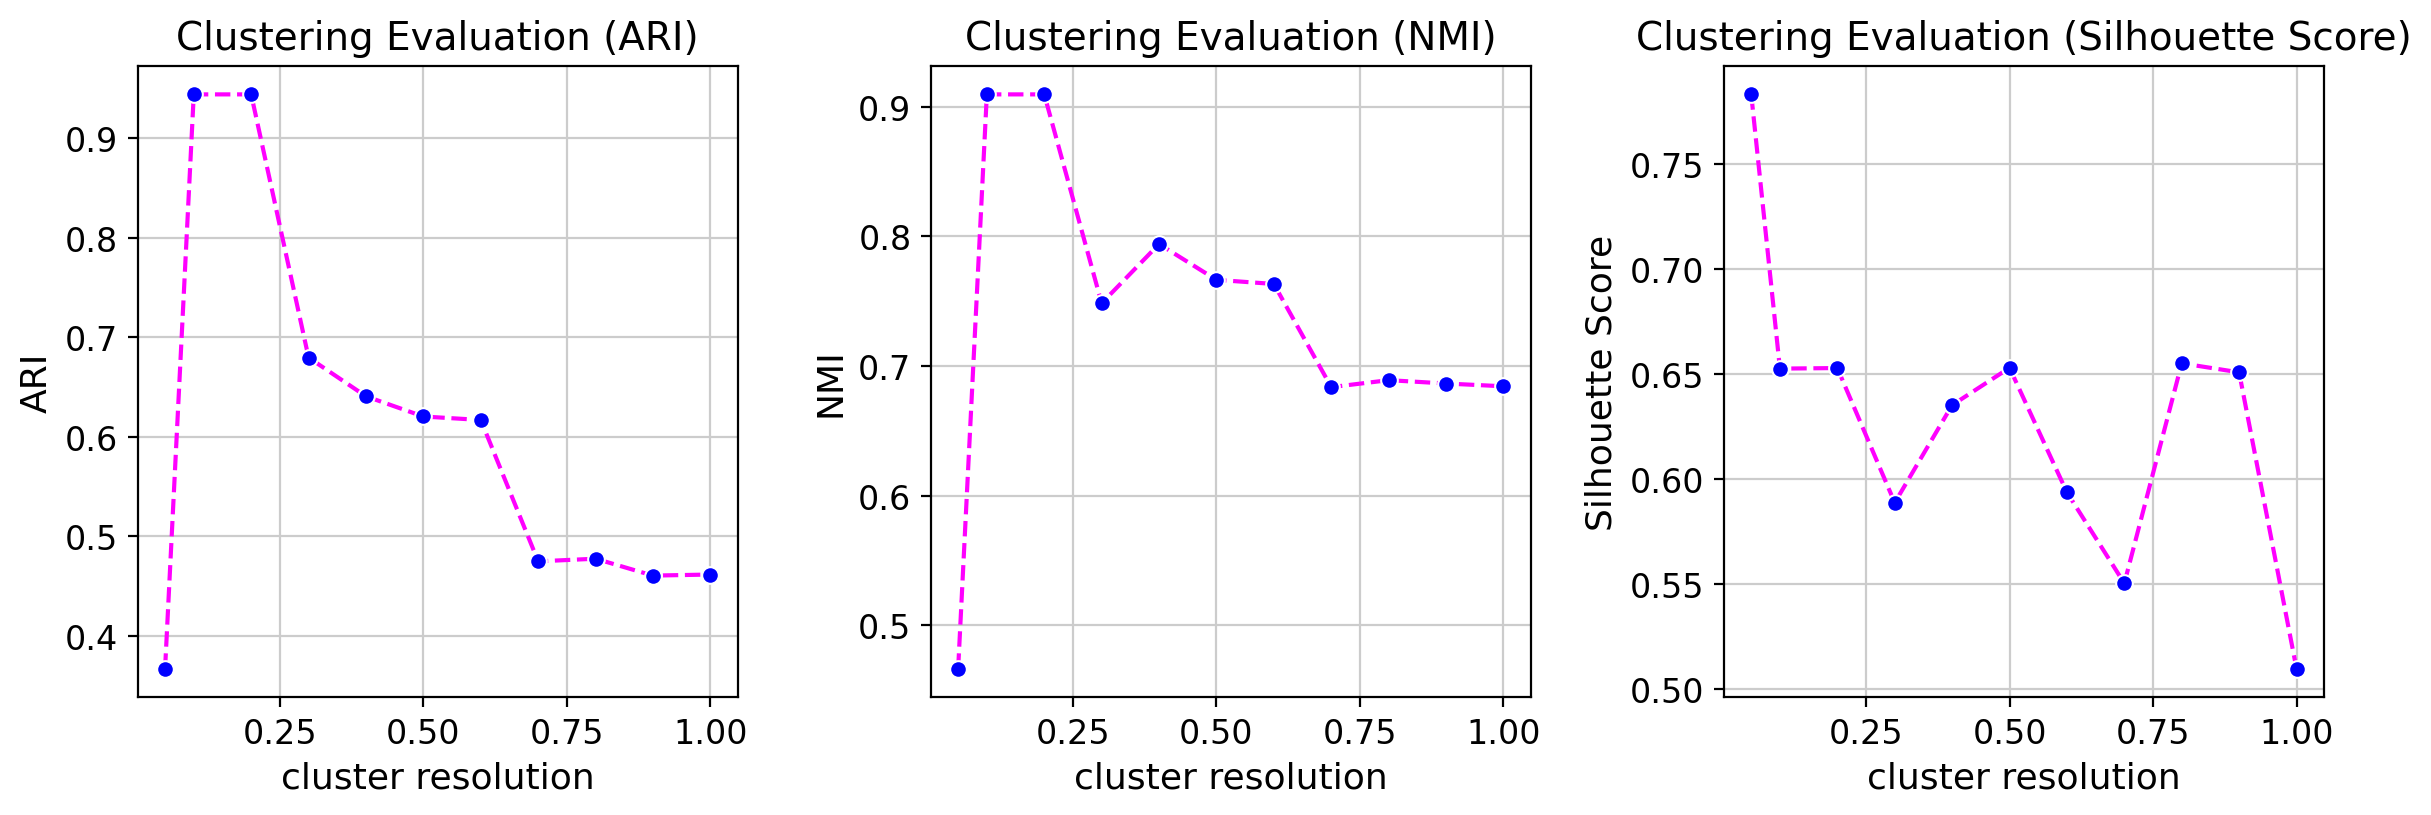

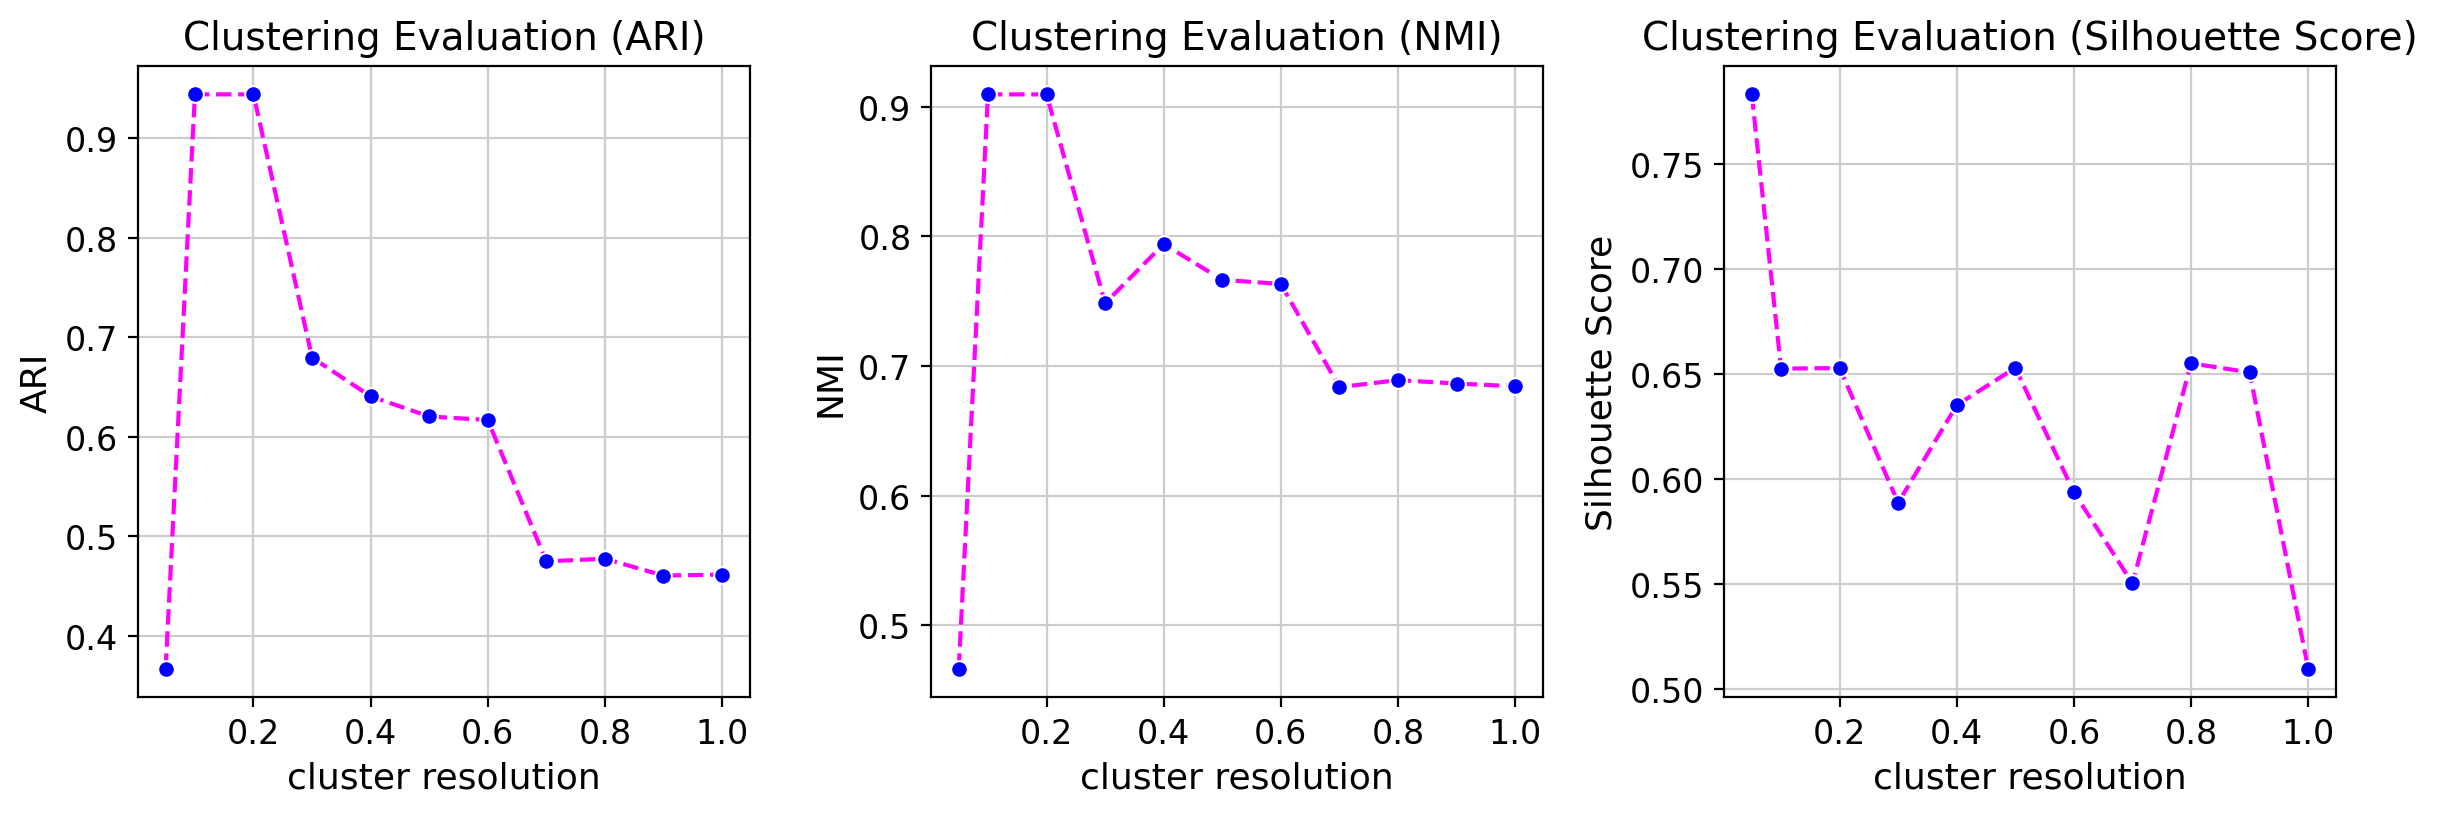

In [36]:
fig = SCREAM.models.tools.plot_clustereval(metrics_df, res_col='cluster resolution', met_cols=None, ncols=5, figsize=None)
fig

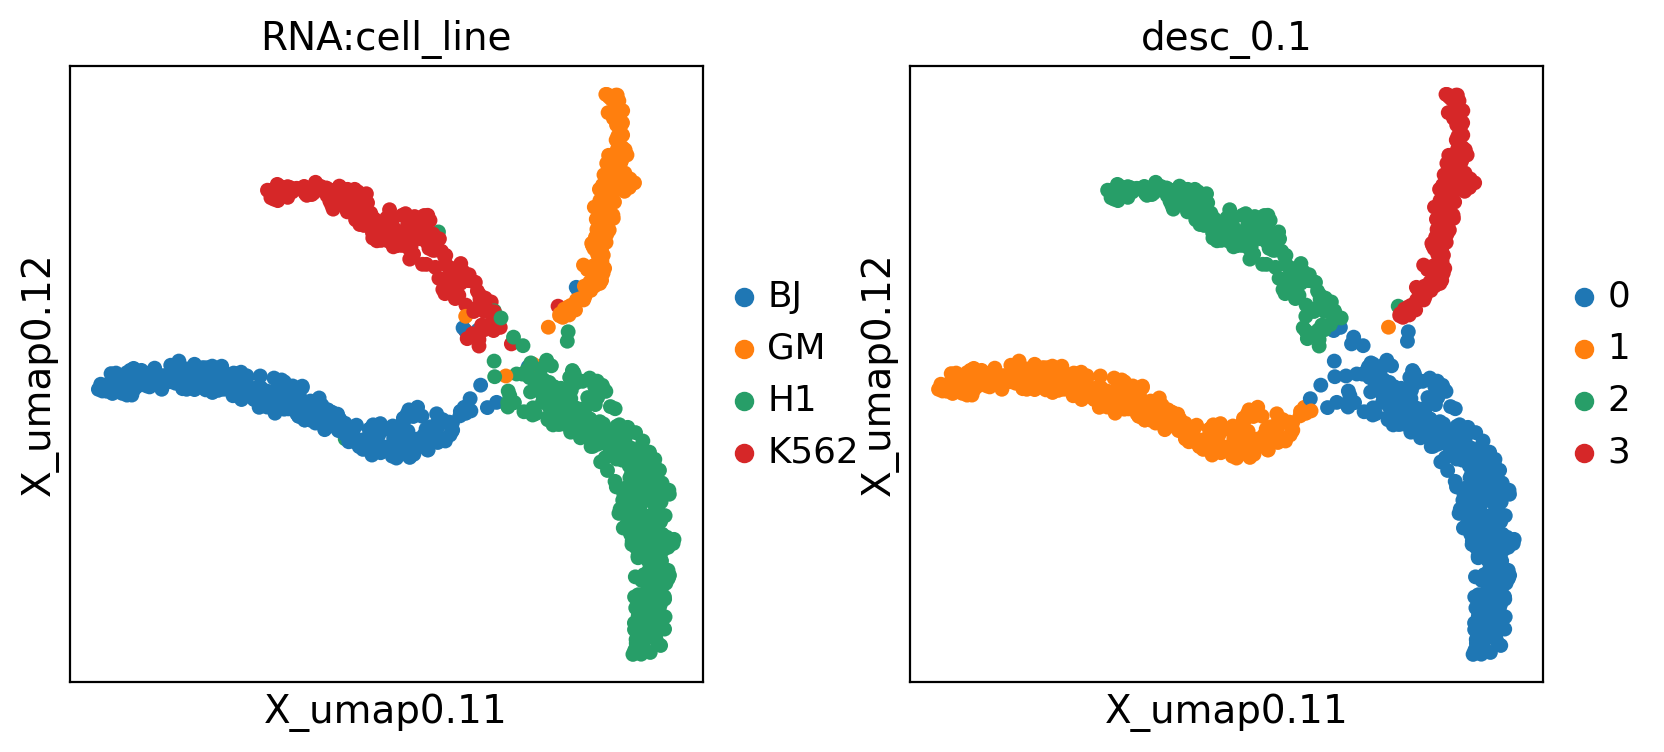

In [37]:
mu.pl.embedding(scream_model.mdata_train, basis='X_umap0.1', color=['RNA:cell_line', 'desc_0.1'])

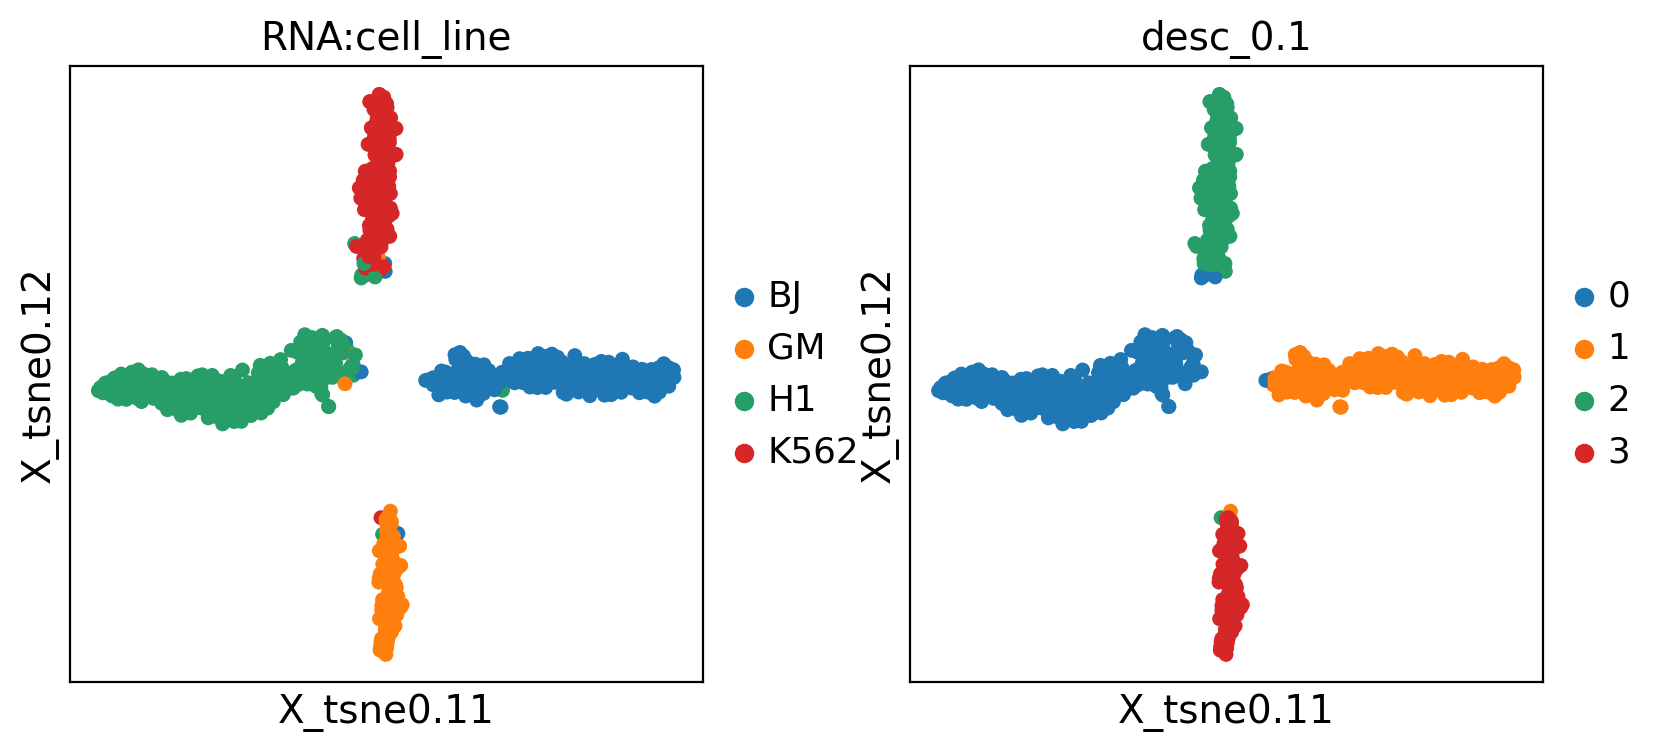

In [38]:
mu.pl.embedding(scream_model.mdata_train, basis='X_tsne0.1', color=['RNA:cell_line', 'desc_0.1'])

In [42]:
scream_model.mdata_train.write_h5mu(os.path.join(processedDir, 'scream_cellline_atac.h5mu'))

## Optional: Tensorboard visualization

In [39]:
get_ipython().run_line_magic("load_ext", "tensorboard")
get_ipython().run_line_magic("tensorboard", f"--logdir {os.path.join(hyper_model.log_dir)} --port 6006")